In [22]:
import re

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler


def scrape_results(url, table_id="events"):
    # Fetch the web page
    response = requests.get(url)
    html_content = response.text

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Find the table
    table = soup.find("table", {"id": table_id})
    rows = table.find_all("tr")

    # Extract headers
    raw_headers = rows[0].find_all("th")
    headers = []
    name_column_index = None

    for i, header in enumerate(raw_headers):
        text = header.text.strip()
        headers.append(text)
        if "Name" in text or "Athlete" in text:
            name_column_index = i

    # Insert additional columns
    if name_column_index is not None:
        headers.insert(name_column_index + 1, "School")
        headers.insert(name_column_index + 2, "Class")

    headers.append("Qualifier")  # Add at end

    data = []
    for row in rows[1:]:
        columns = row.find_all("td")
        row_data = []
        qualifier = ""  # Default in case no <span class="q_qual"> is found

        for i, col in enumerate(columns):
            # Check for qualifier span
            q_span = col.find("span", class_="q_qual")
            if q_span:
                qualifier = q_span.get_text(strip=True)
                q_span.decompose()  # Remove it so it doesn't pollute main text

            if i == name_column_index:
                # Handle name/school/class
                small = col.find("small")
                if small:
                    small_text = small.get_text(strip=True)
                    match = re.match(r"^(.*?)\s*\[(\w+)\]$", small_text)
                    if match:
                        school = match.group(1).strip()
                        class_year = match.group(2).strip()
                    else:
                        school = small_text
                        class_year = ""
                    small.decompose()
                else:
                    school = ""
                    class_year = ""
                name = col.get_text(strip=True)
                row_data.append(name)
                row_data.append(school)
                row_data.append(class_year)
            else:
                row_data.append(col.get_text(strip=True))

        # Ensure row has correct length (padding if necessary)
        while len(row_data) < len(headers) - 1:
            row_data.append("")
        row_data.append(qualifier)
        data.append(row_data)

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=headers)

    # Drop empty column if present
    if "" in df.columns:
        df = df.drop(columns=[""])

    return df


In [2]:
def scrape_multiple_startlist_tables(url, table_id="startlist"):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    tables = soup.find_all("table", {"id": table_id})
    if not tables:
        print(f"No tables found with id='{table_id}'")
        return pd.DataFrame()

    all_rows = []

    for table in tables:
        tbody = table.find("tbody")
        if not tbody:
            continue

        tds = tbody.find_all("td")
        if len(tds) % 7 != 0:
            print(f"Warning: Expected multiple of 7 <td> tags, got {len(tds)}.")

        for i in range(0, len(tds), 7):
            group = tds[i : i + 7]
            if len(group) < 7:
                continue  # skip incomplete row

            sem = group[0].get_text(strip=True)
            pos = group[1].get_text(strip=True)

            athlete_td = group[3]
            name_tag = athlete_td.find("b")
            name = name_tag.get_text(strip=True) if name_tag else ""

            small = athlete_td.find("small")
            school, class_year = "", ""
            if small:
                school_class = small.get_text(strip=True)
                match = re.match(r"^(.*?)\s*\[(\w+)\]$", school_class)
                if match:
                    school = match.group(1)
                    class_year = match.group(2)

            sb = group[4].get_text(strip=True)
            ncaa = group[5].get_text(strip=True)
            pb = group[6].get_text(strip=True)

            all_rows.append(
                {
                    "Sem": sem,
                    "Pos": pos,
                    "Athlete": name,
                    "School": school,
                    "Class": class_year,
                    "SB": sb,
                    "NCAA": ncaa,
                    "PB": pb,
                }
            )

    df = pd.DataFrame(all_rows)
    # df['rank'] = df['NCAA'].astype(int).rank()
    return df


In [3]:
def process_event_results(results_df, start_list_df, event_name):
    merged_df = results_df.merge(
        start_list_df, how="inner", on=["Athlete", "School", "Class"]
    )
    merged_df["NCAA"] = np.where(merged_df["NCAA"] == "", 999, merged_df["NCAA"])
    merged_df["Pl"] = np.where(merged_df["Pl"] == "", 48, merged_df["Pl"])
    merged_df["rank"] = merged_df["NCAA"].astype(int).rank()
    merged_df["qualified"] = np.where(merged_df["Qualifier"] != "", 1, 0)
    merged_df["outperform"] = np.where(
        merged_df["Pl"].astype(int) < merged_df["rank"], 1, 0
    )
    merged_df["event"] = event_name
    return merged_df

In [4]:
m_east_3k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/006-1_start.htm",
)
m_east_3k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/006-1_compiled.htm"
)
m_west_3k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/006-1_start.htm",
)
m_west_3k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/006-1_compiled.htm"
)

In [5]:
m_east_3k = process_event_results(m_east_3k_results, m_east_3k_start, "m_east_3k")
m_west_3k = process_event_results(m_west_3k_results, m_west_3k_start, "m_west_3k")

In [6]:
w_east_3k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/026-1_start.htm",
)
w_east_3k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/026-1_compiled.htm"
)
w_west_3k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/026-1_start.htm",
)
w_west_3k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/026-1_compiled.htm"
)

In [7]:
w_east_3k = process_event_results(w_east_3k_results, w_east_3k_start, "w_east_3k")
w_west_3k = process_event_results(w_west_3k_results, w_west_3k_start, "w_west_3k")

In [8]:
m_east_5k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/007-1_start.htm",
)
m_east_5k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/007-1_compiled.htm"
)
m_west_5k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/007-1_start.htm",
)
m_west_5k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/007-1_compiled.htm"
)

In [9]:
m_east_5k = process_event_results(m_east_5k_results, m_east_5k_start, "m_east_5k")
m_west_5k = process_event_results(m_west_5k_results, m_west_5k_start, "m_west_5k")

In [10]:
w_east_5k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/027-1_start.htm",
)
w_east_5k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/027-1_compiled.htm"
)
w_west_5k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/027-1_start.htm",
)
w_west_5k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/027-1_compiled.htm"
)

In [11]:
w_east_5k = process_event_results(w_east_5k_results, w_east_5k_start, "w_east_5k")
w_west_5k = process_event_results(w_west_5k_results, w_west_5k_start, "w_west_5k")

In [12]:
m_east_10k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/008-1_start.htm",
)
m_east_10k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/008-1_compiled.htm"
)
m_west_10k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/008-1_start.htm",
)
m_west_10k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/008-1_compiled.htm"
)

In [13]:
m_east_10k = process_event_results(m_east_10k_results, m_east_10k_start, "m_east_10k")
m_west_10k = process_event_results(m_west_10k_results, m_west_10k_start, "m_west_10k")

In [14]:
w_east_10k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/028-1_start.htm",
)
w_east_10k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/East/028-1_compiled.htm"
)
w_west_10k_start = scrape_multiple_startlist_tables(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/028-1_start.htm",
)
w_west_10k_results = scrape_results(
    "https://flashresults.ncaa.com/Outdoor/2025/FirstRounds/West/028-1_compiled.htm"
)

In [15]:
w_east_10k = process_event_results(w_east_10k_results, w_east_10k_start, "w_east_10k")
w_west_10k = process_event_results(w_west_10k_results, w_west_10k_start, "w_west_10k")

In [18]:
# Combine all dataframes
combined_df = pd.concat(
    [
        m_east_3k,
        m_west_3k,
        w_east_3k,
        w_west_3k,
        m_east_5k,
        m_west_5k,
        w_east_5k,
        w_west_5k,
        m_east_10k,
        m_west_10k,
        w_east_10k,
        w_west_10k,
    ]
)

In [19]:
# Group by school and perform aggregations
result = (
    combined_df.groupby("School")
    .agg(
        n_regionals=("School", "size"),
        n_nationals=("qualified", "sum"),
        n_outperformed=("outperform", "sum"),
        distinct_events=("event", "nunique"),
    )
    .reset_index()
)

In [23]:
result["perc_qualified"] = result["n_nationals"] / result["n_regionals"]
result["perc_outperformed"] = result["n_outperformed"] / result["n_regionals"]
result["perc_events"] = result["distinct_events"] / 6

scaler = MinMaxScaler()
result["n_regionals_scaled"] = scaler.fit_transform(result[["n_regionals"]])

In [24]:
result["overall_score"] = (
    result["n_regionals_scaled"] * 0.25
    + result["perc_qualified"] * 0.25
    + result["perc_outperformed"] * 0.25
    + result["perc_events"] * 0.25
)

In [25]:
result.sort_values(by="overall_score", ascending=False).head()

,School,n_regionals,n_nationals,n_outperformed,distinct_events,perc_qualified,perc_outperformed,perc_events,n_regionals_scaled,overall_score
83,No. Arizona,20,7,13,6,0.350000,0.650000,1.000000,0.904762,0.726190
82,New Mexico,22,9,8,6,0.409091,0.363636,1.000000,1.000000,0.693182
134,Washington,13,3,9,6,0.230769,0.692308,1.000000,0.571429,0.623626
8,BYU,16,7,5,6,0.437500,0.312500,1.000000,0.714286,0.616071
112,TX A&M,6,3,6,4,0.500000,1.000000,0.666667,0.238095,0.601190


In [85]:
# Rename columns to make them more readable
pretty_columns = {
    "School": "School",
    "n_regionals": "Number of Regional Entries",
    "n_nationals": "Number of National Qualifiers",
    "n_outperformed": "Number of Outperformers",
    "distinct_events": "Distinct Events",
    "n_regionals_scaled": "Number of Regional Entries (Scaled)",
    "perc_qualified": "Percent Qualifying",
    "perc_outperformed": "Percent Outperforming",
    "perc_events": "Percent Events Represented",
    "overall_score": "Overall Score",
}

# Apply the renaming
result_pretty = result.rename(columns=pretty_columns)

# Export the dataframe to a CSV file
result_pretty.sort_values(by="Overall Score", ascending=False).to_csv(
    "result_pretty_overall.csv", index=False
)

# Export the top 5 rows sorted by "Number of Regional Entries (Scaled)"
result_pretty.sort_values(
    by="Number of Regional Entries (Scaled)", ascending=False
).head(5).to_csv("result_pretty_scaled_regionals.csv", index=False)

# Export the top 5 rows sorted by "Percent Qualifying"
result_pretty[result_pretty["Number of Regional Entries"] >= 5].sort_values(
    by="Percent Qualifying", ascending=False
).head(5).to_csv("result_pretty_percent_qualifying.csv", index=False)

# Export the top 5 rows sorted by "Percent Outperforming"
result_pretty[result_pretty["Number of Regional Entries"] >= 5].sort_values(
    by="Percent Outperforming", ascending=False
).head(5).to_csv("result_pretty_percent_outperforming.csv", index=False)

# Export the top 5 rows sorted by "Percent Events Represented"
result_pretty.sort_values(by="Percent Events Represented", ascending=False).head(
    5
).to_csv("result_pretty_percent_events.csv", index=False)

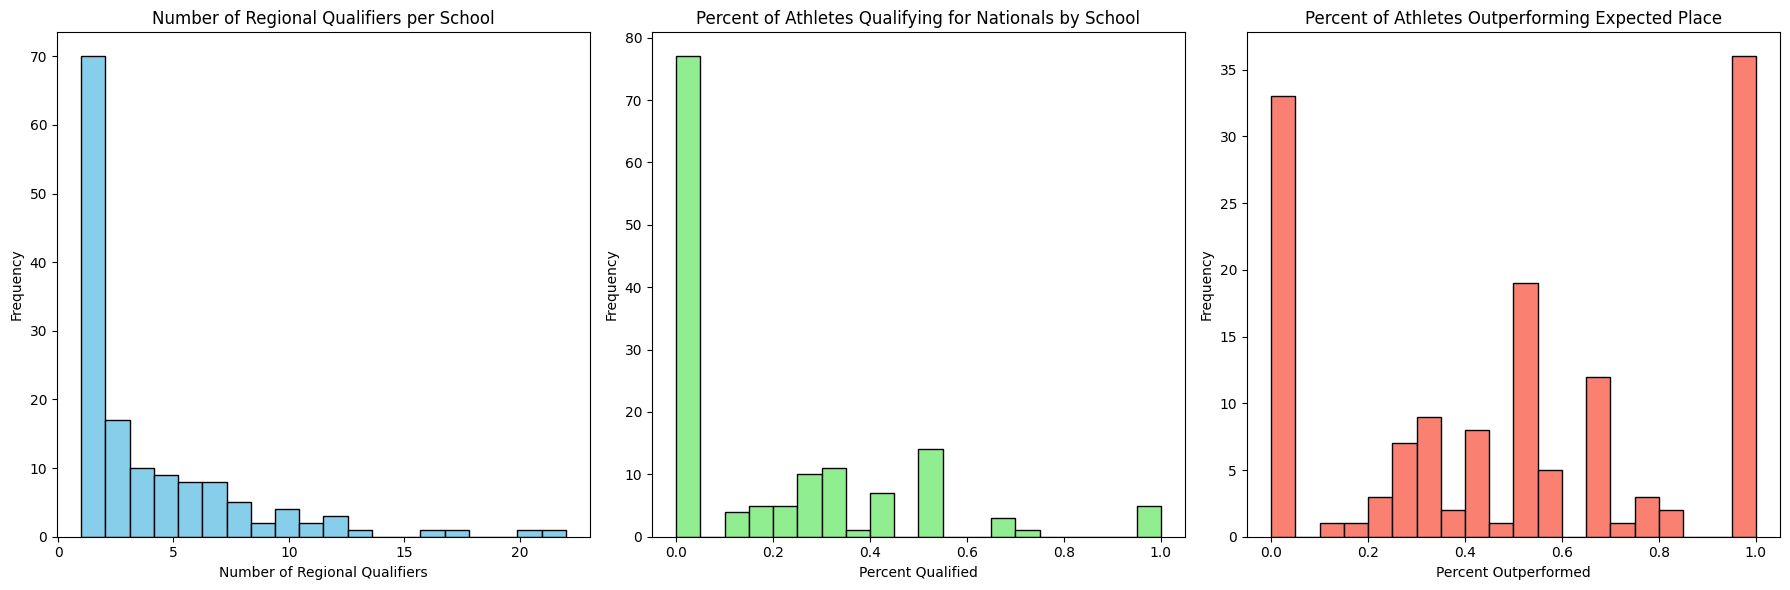

In [86]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram for n_regionals
axes[0].hist(result["n_regionals"], bins=20, color="skyblue", edgecolor="black")
axes[0].set_title("Number of Regional Qualifiers per School")
axes[0].set_xlabel("Number of Regional Qualifiers")
axes[0].set_ylabel("Frequency")

# Histogram for perc_nationals
axes[1].hist(result["perc_qualified"], bins=20, color="lightgreen", edgecolor="black")
axes[1].set_title("Percent of Athletes Qualifying for Nationals by School")
axes[1].set_xlabel("Percent Qualified")
axes[1].set_ylabel("Frequency")

# Histogram for perc_outperformed
axes[2].hist(result["perc_outperformed"], bins=20, color="salmon", edgecolor="black")
axes[2].set_title("Percent of Athletes Outperforming Expected Place")
axes[2].set_xlabel("Percent Outperformed")
axes[2].set_ylabel("Frequency")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [87]:
# Separate men's and women's data
men_df = combined_df[combined_df["event"].str.startswith("m_")]
women_df = combined_df[combined_df["event"].str.startswith("w_")]

# Group by school and perform aggregations for men's data
men_result = (
    men_df.groupby("School")
    .agg(
        n_regionals=("School", "size"),
        n_nationals=("qualified", "sum"),
        n_outperformed=("outperform", "sum"),
        distinct_events=("event", "nunique"),
    )
    .reset_index()
)

# Group by school and perform aggregations for women's data
women_result = (
    women_df.groupby("School")
    .agg(
        n_regionals=("School", "size"),
        n_nationals=("qualified", "sum"),
        n_outperformed=("outperform", "sum"),
        distinct_events=("event", "nunique"),
    )
    .reset_index()
)

# Add percentage columns and scale for men's data
men_result["perc_qualified"] = men_result["n_nationals"] / men_result["n_regionals"]
men_result["perc_outperformed"] = men_result["n_outperformed"] / men_result["n_regionals"]
men_result["perc_events"] = men_result["distinct_events"] / 3
men_result["n_regionals_scaled"] = scaler.fit_transform(men_result[["n_regionals"]])
men_result["overall_score"] = (
    men_result["n_regionals_scaled"] * 0.25
    + men_result["perc_qualified"] * 0.25
    + men_result["perc_outperformed"] * 0.25
    + men_result["perc_events"] * 0.25
)

# Add percentage columns and scale for women's data
women_result["perc_qualified"] = women_result["n_nationals"] / women_result["n_regionals"]
women_result["perc_outperformed"] = women_result["n_outperformed"] / women_result["n_regionals"]
women_result["perc_events"] = women_result["distinct_events"] / 3
women_result["n_regionals_scaled"] = scaler.fit_transform(women_result[["n_regionals"]])
women_result["overall_score"] = (
    women_result["n_regionals_scaled"] * 0.25
    + women_result["perc_qualified"] * 0.25
    + women_result["perc_outperformed"] * 0.25
    + women_result["perc_events"] * 0.25
)

In [88]:
# Apply the renaming for men's data
men_result_pretty = men_result.rename(columns=pretty_columns)

# Export the men's dataframe to CSV files
men_result_pretty.sort_values(by="Overall Score", ascending=False).to_csv(
    "men_result_pretty_overall.csv", index=False
)
men_result_pretty.sort_values(
    by="Number of Regional Entries (Scaled)", ascending=False
).head(5).to_csv("men_result_pretty_scaled_regionals.csv", index=False)
men_result_pretty[men_result_pretty["Number of Regional Entries"] >= 5].sort_values(
    by="Percent Qualifying", ascending=False
).head(5).to_csv("men_result_pretty_percent_qualifying.csv", index=False)
men_result_pretty[men_result_pretty["Number of Regional Entries"] >= 5].sort_values(
    by="Percent Outperforming", ascending=False
).head(5).to_csv("men_result_pretty_percent_outperforming.csv", index=False)
men_result_pretty.sort_values(by="Percent Events Represented", ascending=False).head(
    5
).to_csv("men_result_pretty_percent_events.csv", index=False)

# Apply the renaming for women's data
women_result_pretty = women_result.rename(columns=pretty_columns)

# Export the women's dataframe to CSV files
women_result_pretty.sort_values(by="Overall Score", ascending=False).to_csv(
    "women_result_pretty_overall.csv", index=False
)
women_result_pretty.sort_values(
    by="Number of Regional Entries (Scaled)", ascending=False
).head(5).to_csv("women_result_pretty_scaled_regionals.csv", index=False)
women_result_pretty[women_result_pretty["Number of Regional Entries"] >= 5].sort_values(
    by="Percent Qualifying", ascending=False
).head(5).to_csv("women_result_pretty_percent_qualifying.csv", index=False)
women_result_pretty[women_result_pretty["Number of Regional Entries"] >= 5].sort_values(
    by="Percent Outperforming", ascending=False
).head(5).to_csv("women_result_pretty_percent_outperforming.csv", index=False)
women_result_pretty.sort_values(by="Percent Events Represented", ascending=False).head(
    5
).to_csv("women_result_pretty_percent_events.csv", index=False)

In [89]:
# Print top 5 rows for each column for men's data
print("Men's Data:")
men_result_pretty.sort_values(by="Overall Score", ascending=False).head(20)

Men's Data:


,School,Number of Regional Entries,Number of National Qualifiers,Number of Outperformers,Distinct Events,Percent Qualifying,Percent Outperforming,Percent Events Represented,Number of Regional Entries (Scaled),Overall Score
51,New Mexico,13,5,6,3,0.384615,0.461538,1.000000,1.000000,0.711538
52,No. Arizona,11,4,6,3,0.363636,0.545455,1.000000,0.833333,0.685606
89,Wake Forest,5,3,4,3,0.600000,0.800000,1.000000,0.333333,0.683333
77,Tulane,5,2,4,3,0.400000,0.800000,1.000000,0.333333,0.633333
94,Wyoming,3,2,3,2,0.666667,1.000000,0.666667,0.166667,0.625000
33,IA State,7,4,3,3,0.571429,0.428571,1.000000,0.500000,0.625000
75,TX Tech,4,3,2,3,0.750000,0.500000,1.000000,0.250000,0.625000
7,BYU,8,4,3,3,0.500000,0.375000,1.000000,0.583333,0.614583
31,Harvard,8,2,5,3,0.250000,0.625000,1.000000,0.583333,0.614583
2,Alabama,6,4,2,3,0.666667,0.333333,1.000000,0.416667,0.604167


In [90]:
print("Women's Data:")
women_result_pretty.sort_values(by="Overall Score", ascending=False).head(20)

Women's Data:


,School,Number of Regional Entries,Number of National Qualifiers,Number of Outperformers,Distinct Events,Percent Qualifying,Percent Outperforming,Percent Events Represented,Number of Regional Entries (Scaled),Overall Score
65,No. Arizona,9,3,7,3,0.333333,0.777778,1.000000,1.000,0.777778
106,Washington,5,3,5,3,0.600000,1.000000,1.000000,0.500,0.775000
89,TX A&M,5,2,5,3,0.400000,1.000000,1.000000,0.500,0.725000
2,Arkansas,5,3,3,3,0.600000,0.600000,1.000000,0.500,0.675000
64,New Mexico,9,4,2,3,0.444444,0.222222,1.000000,1.000,0.666667
76,Penn State,6,3,3,3,0.500000,0.500000,1.000000,0.625,0.656250
36,Gonzaga,6,2,4,3,0.333333,0.666667,1.000000,0.625,0.656250
100,Utah,7,2,4,3,0.285714,0.571429,1.000000,0.750,0.651786
5,BYU,8,3,2,3,0.375000,0.250000,1.000000,0.875,0.625000
60,NC State,6,4,1,3,0.666667,0.166667,1.000000,0.625,0.614583
